Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [86]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [0]:
'''因为https://commondatastorage.googleapis.com/books1000/打不开，所以这块代码报错，
数据从http://yaroslavvb.com/upload/notMNIST/下载
'''
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [41]:
num_classes = 10
np.random.seed(133)

train_filename = './notMNIST_large'
test_filename = './notMNIST_small'

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [89]:
num_image_show = 2
character_label_file=['A','B','C','D','E','F','G','H','I','J']
current_path=os.getcwd()
for label_file in character_label_file:
    path = current_path + '/' +test_filename+'/'+label_file
    image_label=os.listdir(path)    #os.listdir 可以将文件中的文件名用列表形式保存下来
    for j in range(num_image_show):
        image_index = random.randint(0,len(image_label))
        image_path = path + '/' + image_label[image_index]
        display(Image(image_path))


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [90]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825015
Standard deviation: 0.44312108
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630443
Standard deviation: 0.4544914
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Full dataset tensor: (52912, 2

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [158]:
import matplotlib.pyplot as plt
with open(train_datasets[1],'r') as f:
    data = pickle.load(f)
    a=(data[2,:,:])
a[0,:]
#plt.plot(a)

array([-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.49607843, -0.49607843, -0.49215686,  0.17058824, -0.27254903,
       -0.5       , -0.49215686, -0.5       , -0.5       , -0.49607843,
       -0.49607843, -0.49607843, -0.49607843, -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       ], dtype=float32)

/home/pineapple/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


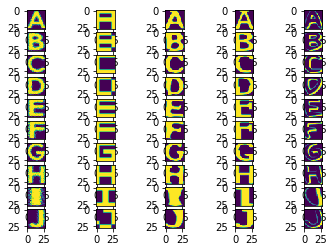

In [159]:
import matplotlib.pyplot as plt
def load_and_displayImage_from_pickle(data_filename_set,NumClass,NumImage):
    if(NumImage <= 0):
        print('NumImage <= 0')
        return
    plt.figure('subplot')
    for index,pickle_file in enumerate(data_filename_set):
        with open(pickle_file,'rb') as f:
            data = pickle.load(f)
            ImageList = data[0:NumImage,:,:]
            for i,Image in enumerate(ImageList):
                #NumClass代表类别，每个类别一行;NumImage代表每个类显示的图像张数
                plt.subplot(NumClass, NumImage, index*NumImage+i+1)
                plt.imshow(Image)
            index = index+1        
#显示10类，每类显示5张图片        
load_and_displayImage_from_pickle(train_datasets,10,5)    
load_and_displayImage_from_pickle(test_datasets,10,5) 

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [176]:
def character_label_detector(train_datasets):
    character_num = {}
    for i in range(len(train_datasets)):
        with open(train_datasets[i],'r') as f:
            data=pickle.load(f)
            character = (train_datasets[i].split('/')[2]).split('.')[0]
            character_num[character]=len(data)
    plt.bar(character_num.keys(),character_num.values())

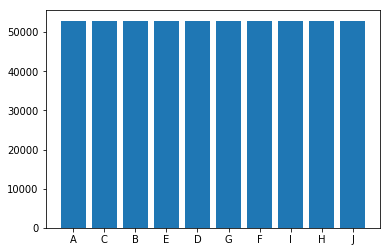

In [175]:
character_label_detector(train_datasets)

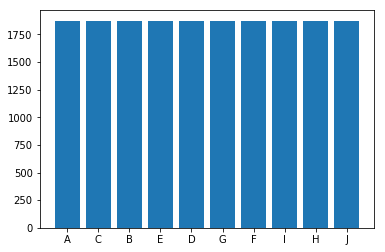

In [174]:
character_label_detector(test_datasets)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [177]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [184]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

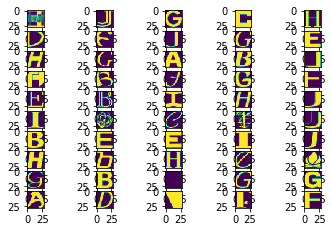

In [185]:
#data_set是数据集，NumImage是显示的图像张数
def displayImage_from_dataset(data_set,NumImage):
    if(NumImage <= 0):
        print('NumImage <= 0')
        return
    plt.figure('subplot')
    ImageList = data_set[0:NumImage,:,:]
    for index,Image in enumerate(ImageList):
        #NumClass代表类别，每个类别一行;NumImage代表每个类显示的图像张数
        plt.subplot(NumImage//5+1, 5, index+1)
        plt.imshow(Image)
        index = index+1    
    plt.show()
displayImage_from_dataset(train_dataset,50)   

Finally, let's save the data for later reuse:

In [188]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [189]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
##ndarray数据无法使用set的方式来求取交集。但如果使用循环对比的方式在数据量大的情况下会非常慢，
##因此，下文的做法使先将数据哈希化，再通过哈希的键值来判断数据是否相等。
##由于哈希的键值是字符串，因此比对起来效率会高很多。

Number of overlaps: 1252


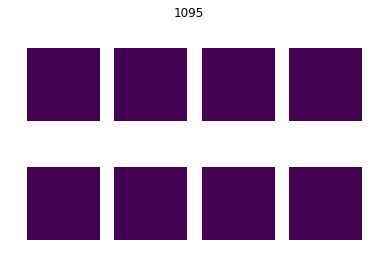

Overlapping images removed from test_dataset:  1252
Overlapping images removed from valid_dataset:  1052
Training: (200000, 28, 28) (200000,)
Validation: (8948,) (8948,)
Testing: (8748, 28, 28) (8748,)
Compressed pickle size: 690800441


In [190]:
#先使用hash
import hashlib

#使用sha的作用是将二维数据和哈希值之间进行一一对应，这样，通过比较哈希值就能将二维数组是否相等比较出来
def extract_overlap_hash_where(dataset_1,dataset_2):

    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

#display the overlap
def display_overlap(overlap,source_dataset,target_dataset):
    overlap = {k: v for k,v in overlap.items() if len(v) >= 3}
    item = np.random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]],target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i,img in enumerate(imgs):
        plt.subplot(2,4,i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

#数据清洗
def sanitize(dataset_1,dataset_2,labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []
    for i,hash1 in enumerate(dataset_hash_1):
        duplictes = np.where(dataset_hash_2 == hash1)
        if len(duplictes[0]):
            overlap.append(i)
    return np.delete(dataset_1,overlap,0),np.delete(labels_1, overlap, None)


overlap_test_train = extract_overlap_hash_where(test_dataset,train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset, train_dataset)

test_dataset_sanit,test_labels_sanit = sanitize(test_dataset,train_dataset,test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))

valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_labels_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)

pickle_file_sanit = 'notMNIST_sanit.pickle'
try:
    f = open(pickle_file_sanit,'wb')
    save = {
        'train_dataset':train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!
---

In [200]:
with open('notMNIST_sanit.pickle','r') as f:
    data_set=pickle.load(f)

    train_dataset=data_set['train_dataset']
    valid_dataset=data_set['valid_dataset']
    test_dataset =data_set['test_dataset']
    train_labels=data_set['train_labels']
    valid_labels=data_set['valid_labels']
    test_labels =data_set['test_labels']

In [213]:
#train_dataset[1,:,:].reshape(1,784)
import sklearn

logistic_regression=sklearn.linear_model.LogisticRegression()
sample_num=3000
train_dataset_sub=train_dataset[:sample_num,:,:].reshape(sample_num,784)
train_labels_sub=train_labels[:sample_num]
logistic_regression.fit(train_dataset_sub,train_labels_sub)
logistic_regression.score(train_dataset_sub,train_labels_sub)

0.9766666666666667

In [223]:
import sklearn

logistic_regression=sklearn.linear_model.LogisticRegression()

def accuracy_sample(train_dataset,train_labels,test_dataset,test_labels,sample_num):
    train_dataset_sub=train_dataset[:sample_num,:,:].reshape(sample_num,784)
    train_labels_sub=train_labels[:sample_num]
    test_dataset_sub=test_dataset[:sample_num,:,:].reshape(sample_num,784)
    test_labels_sub=test_labels[:sample_num]
    
    
    logistic_regression.fit(train_dataset_sub,train_labels_sub)
    
    accuracy_train=logistic_regression.score(train_dataset_sub,train_labels_sub)
    accuracy_test =logistic_regression.score(test_dataset_sub, test_labels_sub)
    
    print('train_accuracy is %s when sample is %s' % (accuracy_train,sample_num))
    print('test_accuracy is %s when sample is %s\n' % (accuracy_test,sample_num))

for sample_num in [50 ,100, 1000, 5000]:
    accuracy_sample(train_dataset,train_labels,test_dataset,test_labels,sample_num)
    

train_accuracy is 1.0 when sample is 50
test_accuracy is 0.54 when sample is 50

train_accuracy is 1.0 when sample is 100
test_accuracy is 0.74 when sample is 100

train_accuracy is 0.996 when sample is 1000
test_accuracy is 0.852 when sample is 1000

train_accuracy is 0.9484 when sample is 5000
test_accuracy is 0.8518 when sample is 5000

